# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Table of Contents

I. [Data Cleaning](#Load-and-Clean-Dataset)<br>
II. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
III. [Feature Engineering](#Feature-Engineering)<br>
IV. [Modeling](#Modeling)<br>

<img src="sparkify.jpg" width="400" height="400">

In [31]:
#! pip install pyspark==3.0.0

In [32]:
# import libraries
import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, isnull, udf, when
from pyspark.sql.types import IntegerType

In [33]:
# create a Spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### 1. Load dataset

In [34]:
path = 'data/mini_sparkify_event_data.json'
df = spark.read.json(path)

In [35]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [36]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [37]:
df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|         

### 2. Check for Missing values

In [38]:
df.count()

286500

In [39]:
# https://stackoverflow.com/questions/44413132/count-the-number-of-missing-values-in-a-dataframe-spark
nans = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
nans.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


*No really missing values, it could be useful to get rid of the 8346 rows with missing values but only if we use one of them as features.*

### 3. Check for Empty values

In [40]:
df.where(df.userId == '').show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [41]:
# remove empty user id
df = df.where(df.userId != '')

In [42]:
df.where(df.sessionId == '').show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



### 4. Duplicates

In [43]:
test = df.dropDuplicates()
test.count()

278154

*No duplicates in hour data set*

### 5. Define timestamps

In [44]:
datetime.datetime.fromtimestamp(1538352117000/1000.0)

datetime.datetime(2018, 10, 1, 2, 1, 57)

In [45]:
get_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

df = df.withColumn("timestamp", get_timestamp(df.ts))
df = df.drop("ts")

df = df.withColumn("registration_timestamp", get_timestamp(df.registration))
df = df.drop("registration")

In [46]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', timestamp='2018-10-01 02:01:57', registration_timestamp='2018-09-29 00:22:42')]

In [47]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, sessionId: bigint, song: string, status: bigint, userAgent: string, userId: string, timestamp: string, registration_timestamp: string]

In [48]:
df.where(df.userId == "2").collect()

[Row(artist='Al Di Meola', auth='Logged In', firstName='Natalee', gender='F', itemInSession=0, lastName='Charles', length=286.40608, level='paid', location='Raleigh, NC', method='PUT', page='NextSong', sessionId=1, song='Roller Jubilee', status=200, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='2', timestamp='2018-10-08 06:49:55', registration_timestamp='2018-09-13 02:49:30'),
 Row(artist='Karamelo Santo', auth='Logged In', firstName='Natalee', gender='F', itemInSession=1, lastName='Charles', length=180.84526, level='paid', location='Raleigh, NC', method='PUT', page='NextSong', sessionId=1, song='El Baile Oficial', status=200, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='2', timestamp='2018-10-08 06:54:41', registration_timestamp='2018-09-13 02:49:30'),
 Row(artist='Hinder', auth='Logged In', firstName='Natalee', 

# Exploratory Data Analysis

When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### 1.1 Define Churn (Cancellation Confirmation)

In [49]:
df.select('page') \
    .dropDuplicates() \
    .count()

19

In [50]:
df.select('page') \
    .dropDuplicates() \
    .show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [51]:
df.groupBy(['userId','page']).agg(count("userId")).sort(desc('userId')).show()

+------+---------------+-------------+
|userId|           page|count(userId)|
+------+---------------+-------------+
|    99|     Add Friend|           12|
|    99|       Settings|            3|
|    99| Submit Upgrade|            1|
|    99|      Thumbs Up|           27|
|    99|      Downgrade|            2|
|    99|    Thumbs Down|            5|
|    99|       NextSong|          505|
|    99|           Help|            1|
|    99|        Upgrade|            2|
|    99|Add to Playlist|           11|
|    99|          About|            2|
|    99|         Logout|            9|
|    99|    Roll Advert|           10|
|    99|           Home|           24|
|    98|           Help|           15|
|    98|  Save Settings|            4|
|    98|      Thumbs Up|          115|
|    98|    Roll Advert|           30|
|    98|       Settings|           13|
|    98|         Logout|           39|
+------+---------------+-------------+
only showing top 20 rows



In [52]:
# count users who stayed vs users who churned
churns = df.groupBy(['userId','page']) \
    .agg(count("userId")) \
    .sort(desc('userId')) \
    .where(df.page == 'Cancellation Confirmation') \
    .withColumnRenamed('count(userId)', 'Churn') \
    .drop("page")
churns.show()

+------+-----+
|userId|Churn|
+------+-----+
|    87|    1|
|    73|    1|
|    70|    1|
|    58|    1|
|    54|    1|
|    53|    1|
|    51|    1|
|    32|    1|
|300007|    1|
|300001|    1|
|     3|    1|
|    29|    1|
|    28|    1|
|200024|    1|
|200021|    1|
|200020|    1|
|200018|    1|
|200017|    1|
|200016|    1|
|200015|    1|
+------+-----+
only showing top 20 rows



In [53]:
# joins Churns to standard df
df = df.join(churns, how='left', on='userId')
df = df.fillna(0)

In [54]:
df.head(1)

[Row(userId='30', artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', timestamp='2018-10-01 02:01:57', registration_timestamp='2018-09-29 00:22:42', Churn=0)]

In [55]:
# separate churns
df_churns = df.where(df.Churn == 1)
df_non_churns = df.where(df.Churn == 0)

In [56]:
df_churns.count(), df_non_churns.count()

(44864, 233290)

### 2. Explore data

For all following rules are always applied
* Churn is always yellow
* Non Churn is always Orange

In [57]:
# transform to pandas for visualization
df_churns_pd = df_churns.toPandas()
df_non_churns_pd = df_non_churns.toPandas()

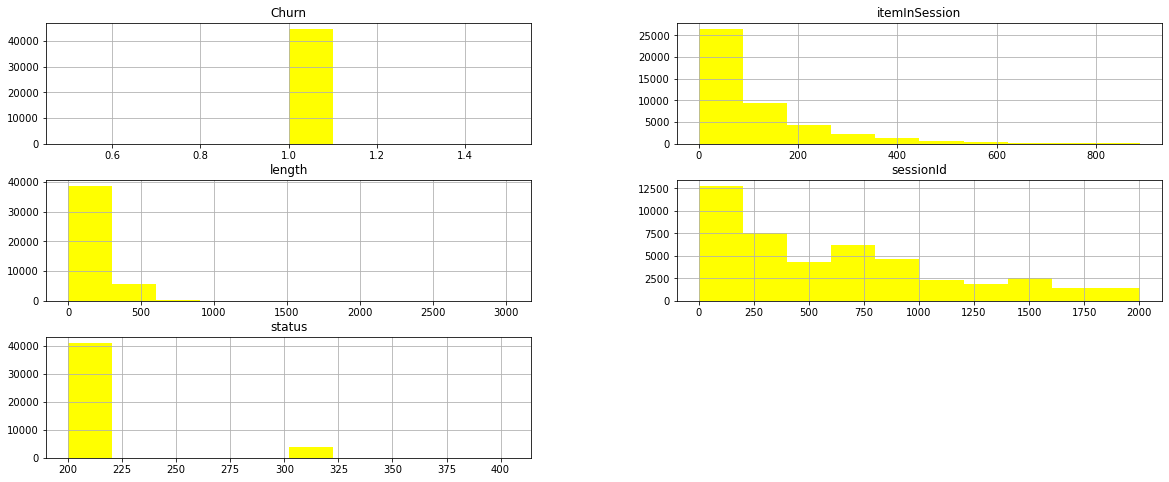

In [58]:
df_churns_pd.hist(figsize=(20,8), color='yellow');

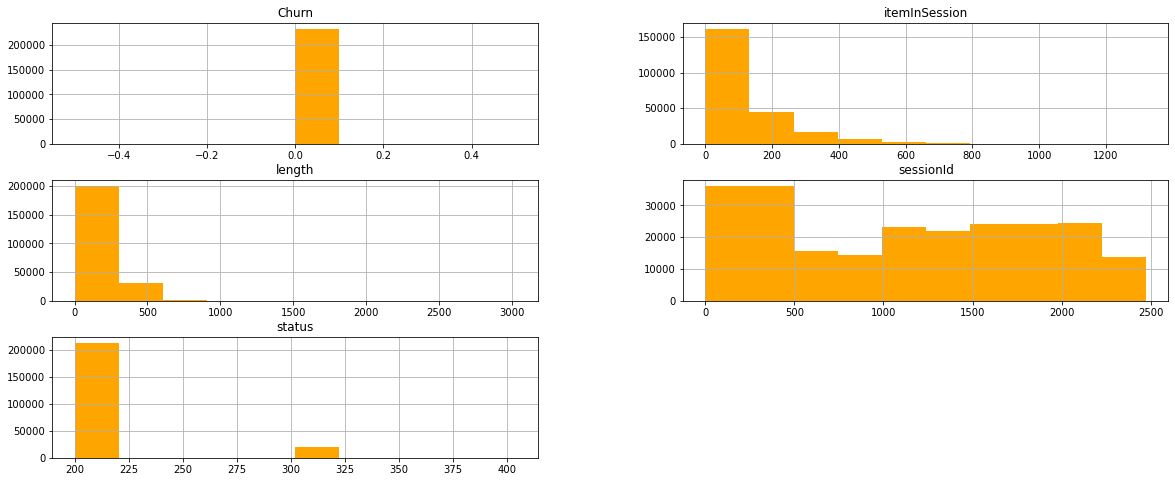

In [59]:
df_non_churns_pd.hist(figsize=(20,8), color='orange');

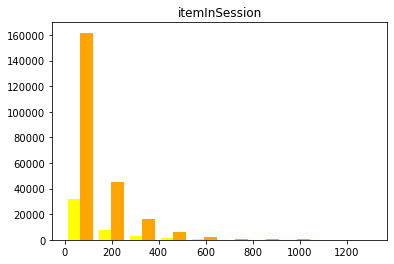

In [60]:
plt.title('itemInSession')
plt.hist([df_churns_pd.itemInSession, df_non_churns_pd.itemInSession], color=['yellow','orange']);

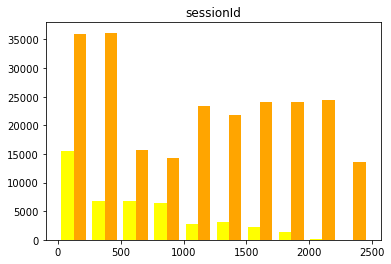

In [61]:
plt.title('sessionId')
plt.hist([df_churns_pd.sessionId, df_non_churns_pd.sessionId], color=['yellow','orange']);

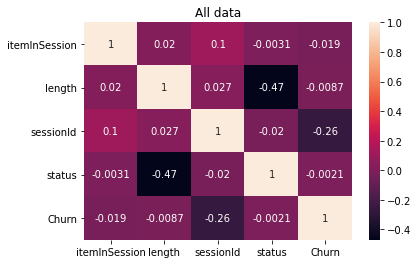

In [62]:
df_pd = df.toPandas()
sns.heatmap(df_pd.corr(), annot=True).set_title('All data')
plt.show()

#### Specific action/page (proportional)

*Because there are a lot more users who didn't churn than users who churned, a proportional comparison is better that an absolute comparison.*

In [63]:
# Churns per page
churns_per_page = df_churns.groupBy(['page']).agg(count("page")/df_churns.count()).sort(desc('page'))
churns_per_page.show()

+--------------------+---------------------+
|                page|(count(page) / 44864)|
+--------------------+---------------------+
|             Upgrade| 0.002496433666191...|
|           Thumbs Up|  0.04143634094151213|
|         Thumbs Down| 0.011055634807417974|
|      Submit Upgrade| 7.132667617689016E-4|
|    Submit Downgrade| 2.006062767475035...|
|            Settings| 0.006018188302425107|
|       Save Settings| 0.001292796005706134|
|         Roll Advert| 0.021554029957203995|
|            NextSong|   0.8112072039942939|
|              Logout|  0.01232614122681883|
|                Home| 0.037268188302425106|
|                Help| 0.005327211126961484|
|               Error| 7.132667617689016E-4|
|           Downgrade| 0.007511590584878745|
|Cancellation Conf...| 0.001159058487874...|
|              Cancel| 0.001159058487874...|
|     Add to Playlist| 0.023136590584878745|
|          Add Friend| 0.014176176890156919|
|               About| 0.001248216833095...|
+---------

In [64]:
# Non Churns per page
non_churns_per_page = df_non_churns.groupBy(['page']).agg(count("page")/df_non_churns.count()).sort(desc('page'))
non_churns_per_page.show()

+----------------+----------------------+
|            page|(count(page) / 233290)|
+----------------+----------------------+
|         Upgrade|  0.001658879506194...|
|       Thumbs Up|   0.04583136868275537|
|     Thumbs Down|  0.008787346221441126|
|  Submit Upgrade|  5.443868146941575E-4|
|Submit Downgrade|   2.31471559003815E-4|
|        Settings|   0.00533241887779159|
|   Save Settings|   0.00108020060868447|
|     Roll Advert|  0.012713789703802134|
|        NextSong|    0.8217840456084702|
|          Logout|  0.011457842170688843|
|            Home|   0.03604955205966823|
|            Help|  0.005208110077585837|
|           Error|    9.4303227742295E-4|
|       Downgrade|  0.007364224784602855|
| Add to Playlist|  0.023524368811350678|
|      Add Friend|  0.015607184191349823|
|           About|  0.001881778044493...|
+----------------+----------------------+



In [65]:
churns_per_page.where(churns_per_page.page == 'Upgrade').show()

+-------+---------------------+
|   page|(count(page) / 44864)|
+-------+---------------------+
|Upgrade| 0.002496433666191...|
+-------+---------------------+



*The greatest difference is Thumbs Down and Submit Upgrade*

#### Thumbs Down

*Because there a lot more user who didn't churn than users who churned, we compare the pages/actions per session.*

In [66]:
def create_new_session_analysis(df_churn, df_non_churns, pageName):
    new_df_churns = df_churns.filter(df_churns.page == pageName) \
        .groupby(df_churns.sessionId).count() \
        .orderBy(df_churns.sessionId.cast("float")) \
        .withColumnRenamed('count', pageName + " (Churns)")
    new_df_non_churns = df_non_churns.filter(df_non_churns.page == pageName) \
        .groupby(df_non_churns.sessionId).count() \
        .orderBy(df_non_churns.sessionId.cast("float")) \
        .withColumnRenamed('count', pageName + " (Non Churns)")
    new_df = new_df_churns.join(new_df_non_churns, how='left', on='sessionId')
    new_df_pd = new_df.drop('sessionId').toPandas()
    
    return new_df, new_df_pd

In [67]:
thumbs, thumbs_pd = create_new_session_analysis(df_churns, df_non_churns,  "Thumbs Down")
thumbs.describe().show()

+-------+------------------+--------------------+------------------------+
|summary|         sessionId|Thumbs Down (Churns)|Thumbs Down (Non Churns)|
+-------+------------------+--------------------+------------------------+
|  count|               235|                 235|                      79|
|   mean| 530.2212765957447|  2.1106382978723404|      1.9367088607594938|
| stddev|503.94467243806156|  1.4309213520040227|      1.2744206542169816|
|    min|                 1|                   1|                       1|
|    max|              2003|                   8|                       8|
+-------+------------------+--------------------+------------------------+



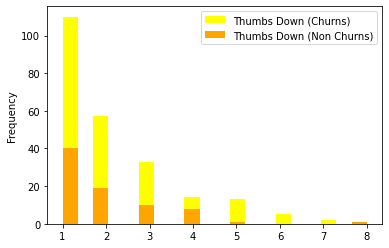

In [68]:
thumbs_pd.plot(kind='hist', color=['yellow','orange'], bins=20);

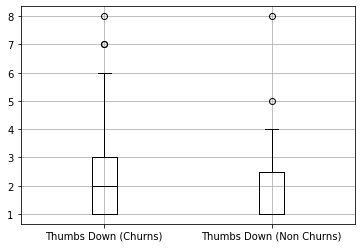

In [69]:
thumbs_pd.boxplot(color='black');

*User who churned are more likely to use 'Thumps Down'*

#### Submit upgrade

In [70]:
upgrade, _ = create_new_session_analysis(df_churns, df_non_churns, "Submit Upgrade")
upgrade.describe().show()

+-------+-----------------+-----------------------+---------------------------+
|summary|        sessionId|Submit Upgrade (Churns)|Submit Upgrade (Non Churns)|
+-------+-----------------+-----------------------+---------------------------+
|  count|               32|                     32|                          2|
|   mean|            467.0|                    1.0|                        1.0|
| stddev|409.7838926918399|                    0.0|                        0.0|
|    min|                1|                      1|                          1|
|    max|             1367|                      1|                          1|
+-------+-----------------+-----------------------+---------------------------+



*User who churned are more likely to use the Submit Upgrade option.*

#### Songs per session

In [71]:
songs_per_session, songs_per_session_pd = create_new_session_analysis(df_churns, df_non_churns, "NextSong")
songs_per_session.describe().show()

+-------+-----------------+-----------------+---------------------+
|summary|        sessionId|NextSong (Churns)|NextSong (Non Churns)|
+-------+-----------------+-----------------+---------------------+
|  count|              456|              456|                  257|
|   mean|556.3048245614035|79.81140350877193|   104.52918287937743|
| stddev|495.1268116604312|93.90422734696361|    101.9232637040991|
|    min|                1|                1|                    1|
|    max|             2003|              708|                  992|
+-------+-----------------+-----------------+---------------------+



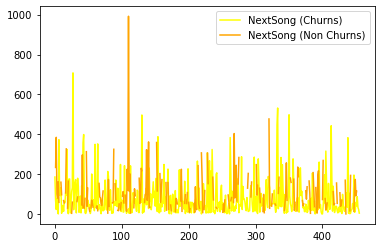

In [72]:
songs_per_session_pd.plot(color=['yellow','orange']);

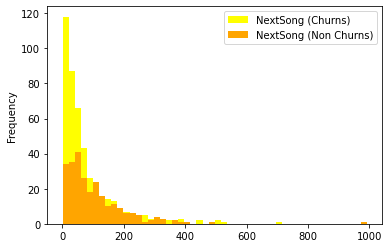

In [77]:
songs_per_session_pd.plot(kind='hist', color=['yellow','orange'], bins=50);

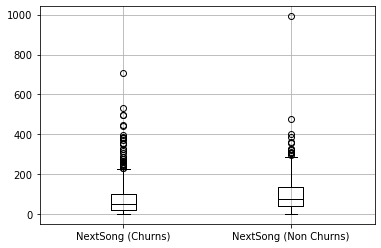

In [78]:
songs_per_session_pd.boxplot(color='black');

*User who churned are more likely to have less songs per session but there are a lot of outliers.*

#### Free vs Paid

In [79]:
level_churn = df_churns.groupby('level').count()
level_churn.show()

+-----+-----+
|level|count|
+-----+-----+
| free|12388|
| paid|32476|
+-----+-----+



In [80]:
level_non_churn = df_non_churns.groupby('level').count()
level_non_churn.show()

+-----+------+
|level| count|
+-----+------+
| free| 43333|
| paid|189957|
+-----+------+



In [81]:
level_pd_churn = level_churn.toPandas().set_index('level')
level_pd_non_churn = level_non_churn.toPandas().set_index('level')

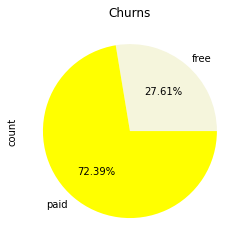

In [82]:
level_pd_churn.plot.pie(y='count', title='Churns', autopct = "%.2f%%", legend=False, colors = ['beige', 'yellow']);

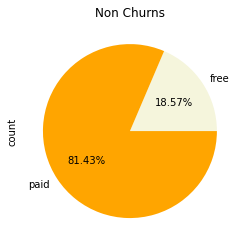

In [83]:
level_pd_non_churn.plot.pie(y='count', title='Non Churns', autopct = "%.2f%%", legend=False, colors = ['beige', 'orange']);

*The Non Churns have a smaller proportion of free users. Free users are more likely to a user who churned.*

#### Gender

In [84]:
gender_churn = df_churns.groupby('gender').count()
gender_churn.show()

+------+-----+
|gender|count|
+------+-----+
|     F|19168|
|     M|25696|
+------+-----+



In [85]:
gender_non_churn = df_non_churns.groupby('gender').count()
gender_non_churn.show()

+------+------+
|gender| count|
+------+------+
|     F|135410|
|     M| 97880|
+------+------+



In [86]:
gender_pd_churn = gender_churn.toPandas().set_index('gender')
gender_pd_non_churn = gender_non_churn.toPandas().set_index('gender')

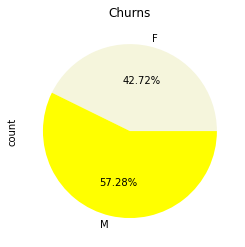

In [87]:
gender_pd_churn.plot.pie(y='count', title='Churns', autopct = "%.2f%%", legend=False, colors = ['beige', 'yellow']);

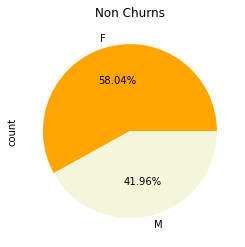

In [88]:
gender_pd_non_churn.plot.pie(y='count', title='Non Churns', autopct = "%.2f%%", legend=False, colors = ['orange', 'beige']);

*The proportion of gender is almost similar*

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Feature #1 Free/Paid User

In [52]:
# level to 0/1
level_transform = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
level = df.withColumn("User Type", level_transform(df.level))
df_features = level.select('User Type', 'userId', 'sessionId', 'Churn')
df_features.head()

Row(User Type=1, userId='30', sessionId=29, Churn=0)

#### Feature #2 Next Song per Session

In [53]:
def create_new_session_cols(df, new_df, colnames):
    for colname in colnames:
        new_col = df.filter(df.page == colname) \
                .groupBy(['userId','sessionId']).count() \
                .withColumnRenamed('count', colname) \
                .drop('sessionId')
        new_df = new_df.join(new_col, how='left', on='userId')
    return new_df

df_features = create_new_session_cols(df, df_features, ['NextSong'])
df_features = df_features.fillna(0)
df_features.head()

Row(userId='100010', User Type=0, sessionId=31, Churn=0, NextSong=80)

#### Transform data

In [54]:
assembler = VectorAssembler(inputCols=['NextSong', 'User Type'], outputCol="numCols")
data = assembler.transform(df_features)
standardscaler = StandardScaler().setInputCol("numCols").setOutputCol("features")
data = standardscaler.fit(data).transform(data)

data = data.select(col("Churn").alias("label"), col("features"))
data.persist()

DataFrame[label: bigint, features: vector]

#### Test Duplicate removal

In [55]:
data_unique = data.dropDuplicates() # because we only have one/some values for each user

#### Test  weighting

In [56]:
# balance data (because we hava a lot more non Churns than Churns)
# see https://stackoverflow.com/questions/33372838/dealing-with-unbalanced-datasets-in-spark-mllib

balancing_ratio = data.where(data.label == 0).count()/data.count()
data_weighted = data.withColumn("classWeights", when(data.label == 0, balancing_ratio).otherwise(1-balancing_ratio))

# Modeling

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Split the data set

In [57]:
train, test = data.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

In [58]:
train.groupby('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    0|6173015|
|    1| 667991|
+-----+-------+



In [59]:
train_weighted, _ = data_weighted.randomSplit([0.9, 0.1], seed=42)
train_weighted = train_weighted.cache()

In [60]:
train_weighted.groupby('label', 'classWeights').count().show()

+-----+-------------------+-------+
|label|       classWeights|  count|
+-----+-------------------+-------+
|    1|0.09761745476361039| 667991|
|    0| 0.9023825452363896|6173015|
+-----+-------------------+-------+



In [61]:
train_unique, _ = data_unique.randomSplit([0.9, 0.1], seed=42)
train_unique = train_unique.cache()

In [62]:
train_unique.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  625|
|    1|  317|
+-----+-----+



#### LogisticRegression

In [63]:
def logistic_regression_train_and_summarize(train, threshold=False, weighted=False):
    
    if weighted:
        lr = LogisticRegression(weightCol="classWeights", maxIter=10)
    else:
        lr = LogisticRegression(maxIter=10)
        
    
    if threshold:
        lr.setThreshold(threshold)
    
    start_time = time.time()
    lr_model = lr.fit(train)
    end_time = time.time()
    print("Training Time: {0:.4f} seconds".format(end_time - start_time))
    
    training_summary = lr_model.summary
    print("Accuracy: {}\nF-measure: {}".format(training_summary.accuracy, training_summary.weightedFMeasure()))

    print("Precision by label:")
    for i, prec in enumerate(training_summary.precisionByLabel):
        print("label %d: %s" % (i, prec))

    print("Recall by label:")
    for i, rec in enumerate(training_summary.recallByLabel):
        print("label %d: %s" % (i, rec))

    print("F-measure by label:")
    for i, f in enumerate(training_summary.fMeasureByLabel()):
        print("label %d: %s" % (i, f))

    # Set the model threshold to maximize F-Measure
    fMeasure = training_summary.fMeasureByThreshold
    maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
    bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
    
    return lr_model, bestThreshold

In [64]:
lr_model, lr_model_threshold = logistic_regression_train_and_summarize(train)

Training Time: 30.9556 seconds
Accuracy: 0.9023548583351629
F-measure: 0.8560382799176114
Precision by label:
label 0: 0.9023548583351629
label 1: 0.0
Recall by label:
label 0: 1.0
label 1: 0.0
F-measure by label:
label 0: 0.9486714367527147
label 1: 0.0


In [65]:
lr_model_weighted, lr_model_threshold_weighted = logistic_regression_train_and_summarize(train_weighted, weighted=True)

Training Time: 32.5374 seconds
Accuracy: 0.9023548583351629
F-measure: 0.8560382799176114
Precision by label:
label 0: 0.9023548583351629
label 1: 0.0
Recall by label:
label 0: 1.0
label 1: 0.0
F-measure by label:
label 0: 0.9486714367527147
label 1: 0.0


In [66]:
lr_model_unique, lr_model_threshold_unique = logistic_regression_train_and_summarize(train_unique)

Training Time: 3.9039 seconds
Accuracy: 0.6666666666666666
F-measure: 0.5859374999999999
Precision by label:
label 0: 0.6777142857142857
label 1: 0.5223880597014925
Recall by label:
label 0: 0.9488
label 1: 0.11041009463722397
F-measure by label:
label 0: 0.7906666666666665
label 1: 0.18229166666666666


Accuracy and F-Measure are not bad but the F-Measure of label 1 is really bad and this metric is really important for avoiding/predicting that a user churns.

Let's try to improve this metric by using the best F1 threshold. 

In [67]:
lr_model, lr_model_threshold = logistic_regression_train_and_summarize(train, threshold=lr_model_threshold)

Training Time: 32.4085 seconds
Accuracy: 0.7611244603498374
F-measure: 0.7955698747928712
Precision by label:
label 0: 0.9162232262168034
label 1: 0.15210173963893633
Recall by label:
label 0: 0.8092729403703053
label 1: 0.3161764155505089
F-measure by label:
label 0: 0.8594335689341074
label 1: 0.20539494445808643


In [68]:
lr_model_weighted, lr_model_threshold_weighted = logistic_regression_train_and_summarize(train_weighted, threshold=lr_model_threshold_weighted ,weighted=True)

Training Time: 33.3745 seconds
Accuracy: 0.7611244603498374
F-measure: 0.7955698747928712
Precision by label:
label 0: 0.9162232262168034
label 1: 0.15210173963893633
Recall by label:
label 0: 0.8092729403703053
label 1: 0.3161764155505089
F-measure by label:
label 0: 0.8594335689341074
label 1: 0.20539494445808643


In [69]:
lr_model_unique, lr_model_threshold_unique = logistic_regression_train_and_summarize(train_unique, threshold=lr_model_threshold_unique)

Training Time: 3.8364 seconds
Accuracy: 0.5859872611464968
F-measure: 0.5914187270302529
Precision by label:
label 0: 0.8254847645429363
label 1: 0.43717728055077454
Recall by label:
label 0: 0.4768
label 1: 0.8012618296529969
F-measure by label:
label 0: 0.6044624746450304
label 1: 0.5657015590200445


F-Measure of label 1 is getting better. Let's try to optimze the result by parameter tuning. Because weighting does not seem to change the results, we drop this configuration for the next step. It's the same result as without weighting.

#### Parameter Tuning

In [71]:
lr = LogisticRegression()

paramGrid = ParamGridBuilder()\
    .addGrid(lr.threshold,[lr_model_threshold]) \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(lr.regParam,[0.01, 0.5, 2.0]) \
    .addGrid(lr.fitIntercept,[False, True])\
    .addGrid(lr.maxIter, [10, 15])\
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [72]:
cvModel_lr = crossval_lr.fit(train)

In [73]:
cvModel_lr.avgMetrics

[0.5366109908154241,
 0.5366109908154241,
 0.570290093043052,
 0.570290093043052,
 0.5366732613815208,
 0.5366732613815208,
 0.5703188574707733,
 0.5703188574707733,
 0.5366734328215866,
 0.5366734328215866,
 0.5703188574707733,
 0.5703188574707733,
 0.5366379950743797,
 0.5366378610923304,
 0.5703188574707733,
 0.5703188574707733,
 0.5534829625205855,
 0.5534829625205855,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5366725646715514,
 0.5366725646715514,
 0.5534829625205855,
 0.5534829625205855,
 0.5534829625205855,
 0.5534829625205855,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]

In [88]:
def visualize_cv_model(cv_model, test):
    results = cv_model.transform(test)
    
    print("Accuracy on test data: {0:.4f}".format(results.filter(results.label == results.prediction).count() / results.count()))
    print("Total count of Label 1 prediction: {}".format(results.filter(results.prediction == '1.0').count()))
    print("Total count of Label 1 expectations: {}".format(results.filter(results.label == '1.0').count()))
    
    results_pd = results.toPandas()
    results_pd.prediction.plot(kind='hist', legend=True);
    results_pd.label.plot(kind='hist', title='Model evaluation', legend=True);

Accuracy on test data: 0.7786
Total count of Label 1 prediction: 134437
Total count of Label 1 expectations: 73990


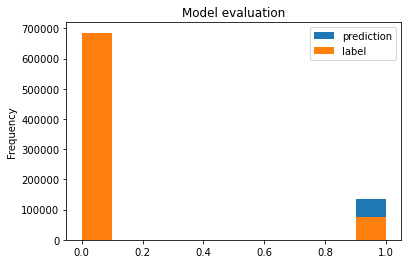

In [89]:
visualize_cv_model(cvModel_lr, test)

In [92]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.threshold,[lr_model_threshold_unique]) \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(lr.regParam,[0.01, 0.5, 2.0]) \
    .addGrid(lr.fitIntercept,[False, True])\
    .addGrid(lr.maxIter, [10, 15])\
    .build()

crossval_unique = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [93]:
cvModel_unique = crossval_unique.fit(train_unique)

In [94]:
cvModel_unique.avgMetrics

[0.6742247507054252,
 0.6742247507054252,
 0.6747572832355059,
 0.6747572832355059,
 0.6593154495616028,
 0.6593154495616028,
 0.6747770185090635,
 0.6747770185090635,
 0.6471012341813782,
 0.6471012341813782,
 0.6748331050514261,
 0.6748331050514261,
 0.6747581097033988,
 0.6747581097033988,
 0.6750815894510674,
 0.6750815894510673,
 0.6749412622079364,
 0.6749412622079364,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.6750129350309727,
 0.6750129350309727,
 0.6749412622079364,
 0.6749412622079364,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]

Accuracy on test data: 0.5754
Total count of Label 1 prediction: 597
Total count of Label 1 expectations: 317


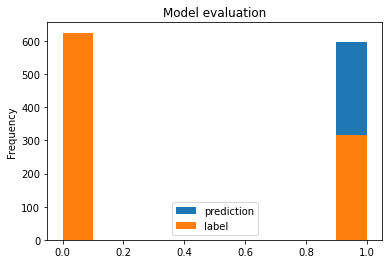

In [96]:
visualize_cv_model(cvModel_unique, train_unique)

**Conclusion**

We have seen three different data inputs for our model (using the same features: Songs per Session + User Type)
* all data set
* weighted data set
* unique data set

In the first round, the best accuracy and f measure were achieved by *all data* and *weighted data*. They both achieved the same result. But the unique data set achieved the best f measure of the label 1.

In the second round, we used the best threshold based on the maximum of f measure. The total accuracy and f measure dropped but the f measure of label 1 raised. The best f 1 measure (label 1) was achieved by the unique data set and the best total accuracy and f measure by the other two data sets.

The last round (parameter tuning) used different parameters to optimize the average metrics. We dropped the weighted data set in this round because the metrics for all data and weighted data were the same. After parameter tuning, the unique data set predicted 597 of 317 expected label 1 values with an accuracy on the test data of 0.5754 while all data set predicted 134437 of 73990 expected label 1 value with an accuracy of 0.7786 on the test data. 

The best model is the one which uses all data of the features we have chosen. The total accuracy and f score are less than of other tested models but it delivers the best prediction of label 1 values which is the main use case of the model.